In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from tensorflow.python.keras.models import Model, load_model
from PIL import Image
PATH = "../tubs/tub6_more_data" #Shadow

C:\Users\allace\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#make sure tensorflow version is the same as one installed on donkeycar (1.8.0)
print(tf.__version__)

1.8.0


In [3]:
from tensorflow.python.client import device_lib
import numpy as np

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

[]

In [4]:
#create df from path
def df_from_jsons(PATH, max_items=None):
    
    #Get json files from path
    json_files = np.array([file for file in os.listdir(PATH) if file.endswith('json') ])
    json_files = json_files[1:]
    np.random.shuffle(json_files)
    
    df = pd.DataFrame()
    for i in json_files[1:max_items+1]:
        with open(f'{PATH}/{i}') as f:
            data = json.load(f)

            userThrottle = data["user/throttle"]
            userAngle = data["user/angle"]
            camImage_path = data["cam/image_array"]
            index = int(camImage_path[:-21])
            camImage_path =  PATH + "/" + camImage_path
            df_row = pd.DataFrame([[userThrottle, userAngle, camImage_path]], index = [index], 
                                  columns = ["user/throttle", "user/angle", "cam/image_array"])

            df = df.append(df_row)
    df = df.sort_index()
    print("Loaded {} json files".format(len(json_files[1:max_items])))
    return df

In [5]:
#df_test = df_from_jsons(PATH, max_items=8000)

In [6]:
#df_test.to_feather('tmp/df_test')

In [7]:
df_test = pd.read_feather('tmp/df_test')

C:\Users\allace\Anaconda3\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [8]:
df_test.shape

(7999, 4)

In [9]:
df_test.head()

,index,user/throttle,user/angle,cam/image_array
0,9,0.44,0.01,../tubs/tub6_more_data/9_cam-image_array_.jpg
1,20,0.34,0.01,../tubs/tub6_more_data/20_cam-image_array_.jpg
2,26,0.06,-0.17,../tubs/tub6_more_data/26_cam-image_array_.jpg
3,28,0.08,-0.20,../tubs/tub6_more_data/28_cam-image_array_.jpg
4,31,0.12,-0.25,../tubs/tub6_more_data/31_cam-image_array_.jpg


In [10]:
model = load_model("./models/speedup3dcnn/pilot_3Dspeedup_2Dense")

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 3, 120, 160,  0                                            
__________________________________________________________________________________________________
cropping3d_6 (Cropping3D)       (None, 3, 60, 160, 3 0           img_in[0][0]                     
__________________________________________________________________________________________________
conv3d_6 (Conv3D)               (None, 1, 14, 39, 4) 904         cropping3d_6[0][0]               
__________________________________________________________________________________________________
max_pooling3d_6 (MaxPooling3D)  (None, 1, 7, 19, 4)  0           conv3d_6[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [12]:
def get_prev_img_names(img_name, quantity, skipFrame = 1):
    img_names = []
    last_name = img_name
    for i in range(0, quantity):
        path = img_name.split("/")
        index = int(path[-1][:-21])-i*skipFrame
        if index < 0:
            name = last_name
        else:
            path[-1] = str(index) + "_cam-image_array_.jpg"
            name = "/".join(path)
        
        img_names.append(name)
        last_name = name
    img_names.reverse()
    return img_names

In [13]:
get_prev_img_names("3_cam-image_array_.jpg", 3)

['1_cam-image_array_.jpg', '2_cam-image_array_.jpg', '3_cam-image_array_.jpg']

In [14]:
def read_record(record_dict, path = PATH, stacked = True):
    data = {}
    for key, val in record_dict.items():
        if key == 'cam/image_array':
            if stacked == True:
                img_names = get_prev_img_names(val, 3)
                val_array = []
                for name in img_names:
                    img_array = np.array(Image.open(name))
                    
                    val_array.append(img_array)
                val = np.array(val_array)
            else:
                img = Image.open(val)
                val = np.array(img)
        data[key] = val
    return data

In [15]:
record_dict = df_test.sample(n=1).to_dict(orient='record')[0]
record = read_record(record_dict)
img_arrays = record['cam/image_array']

In [16]:
img_arrays.shape

(3, 120, 160, 3)

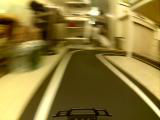

In [17]:
Image.fromarray(img_arrays[0])

In [18]:
def get_record_gen(record_transform=None, shuffle=True, df=None):
    while True:
        for _ in df.iterrows():
            if shuffle:
                record_dict = df.sample(n=1).to_dict(orient='record')[0]
            
            record_dict = read_record(record_dict)
            
            if record_transform:
                record_dict = record_transform(record_dict)
            
            yield record_dict

In [19]:
def get_batch_gen(keys=None, batch_size=128, record_transform=None, shuffle=True, df=None):
    
    record_gen = get_record_gen(record_transform=record_transform, shuffle=shuffle, df=df)
    
    while True:
        record_list = [next(record_gen) for _ in range(batch_size)]
        
        batch_arrays = {}
        for i, k in enumerate(keys):
            arr = np.array([r[k] for r in record_list])
            batch_arrays[k] = arr
        yield batch_arrays

In [20]:
def get_train_gen(X_keys, Y_keys, batch_size=128, record_transform=None, df=None): #
    batch_gen = get_batch_gen(X_keys + Y_keys, batch_size=batch_size,
                                  record_transform=record_transform, df=df)
    while True:
        batch = next(batch_gen)
        X = [batch[k] for k in X_keys]
        Y = [batch[k] for k in Y_keys] 
        yield X, Y

In [21]:
def get_train_val_gen(df, X_keys, Y_keys, batch_size = 128, train_frac=0.8, #
                      train_record_transform=None, val_record_transform=None): #
    train_df = df.sample(frac=train_frac, random_state=200) #
    val_df = df.drop(train_df.index) #
    
    train_gen = get_train_gen(X_keys=X_keys, Y_keys=Y_keys, batch_size=batch_size,
                             record_transform=train_record_transform, df=train_df)
    val_gen = get_train_gen(X_keys=X_keys, Y_keys=Y_keys, batch_size=batch_size,
                           record_transform=val_record_transform, df=val_df)
    return train_gen, val_gen

In [22]:
def record_transform(record):
    record['user/angle'] = to_bin(record['user/angle'])
    return record

In [23]:
X_keys = ['cam/image_array']
y_keys = ['user/angle', 'user/throttle']
bs = 128 # or 128/3
train_frac = 1
new_model_path = 'models/pilot_jp_2'

In [24]:
def to_bin(a):
    arr = np.zeros(15)
    a = a + 1
    b = round(a/(2/14))
    arr[int(b)] = 1
    return arr

In [25]:
test_gen, _ = get_train_val_gen(df_test, X_keys, y_keys,
                                               train_record_transform=record_transform, #
                                               val_record_transform=record_transform, #
                                               batch_size=bs, #
                                               train_frac=train_frac) #

In [26]:
model.metrics_names

['loss', 'angle_out_loss', 'throttle_out_loss']

In [27]:
model.evaluate_generator(test_gen, steps=50)

[2.1641774678230288, 2.4039510011672975, 0.062162109911441804]